<div class="alert alert-block alert-info">
<b>Project structure</b>

Data
- Loading the data / preprocessing
- Feature engeneering
- Datasets: Train, Test splitting

Model
- PPO algorithm
- Actor and Critic Neural Networks
- Environment
- Agent
- Training
- Evaluation
- Results


</div>

In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yfinance as yf
from sklearn.model_selection import train_test_split
from torch.distributions import Categorical
from tqdm import tqdm
from pandas import set_option
import warnings

np.random.seed(11)
random.seed(11)
torch.manual_seed(11)

warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b>Loading the data</b>

- Gas price dataset
- Preprocessing
</div>

In [2]:
stock = 'BZ=F'
start = '2007-07-30'
end = '2024-04-01'

dataset = yf.download(stock, start, end)
print("Number of entries in the dataset:", len(dataset))

[*********************100%%**********************]  1 of 1 completed

Number of entries in the dataset: 4137


## Data cleaning

In [3]:
dataset['percent change']=dataset['Close'].pct_change()

In [4]:
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume,percent change
Date,,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575,NaN
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513,0.017296
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930,-0.022064
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180,0.005441
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387,-0.013332


<Axes: xlabel='Date'>

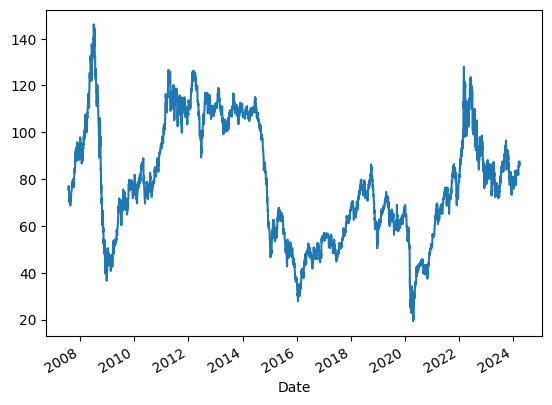

In [5]:
dataset['Close'].plot()

count    4136.000000
mean        0.000330
std         0.024264
min        -0.244036
25%        -0.010213
50%         0.000537
75%         0.011412
max         0.315466
Name: percent change, dtype: float64
missing values:  1


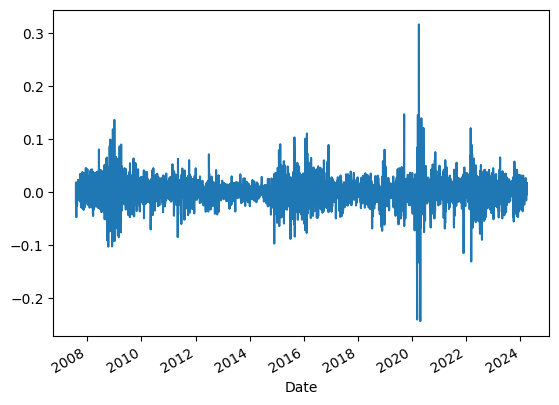

In [6]:
dataset['percent change'].plot()
print(dataset['percent change'].describe())
print("missing values: ", dataset['percent change'].isnull().sum())

# Drop the missing values
dataset = dataset.dropna()

In [7]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [8]:
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume,percent change
Date,,,,,,,
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513,0.017296
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930,-0.022064


<div class="alert alert-block alert-info">
<b>Feature engineering</b>

- MACD: Moving Average Convergence Divergence
- RSI: Relative Strength Index

</div>

In [9]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))

calculate_macd(dataset)
calculate_rsi(dataset)
# Drop NaN values that were introduced by the calculations
dataset.dropna(inplace=True)

dataset.columns


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'percent change', 'MACD',
       'Signal_Line', 'RSI'],
      dtype='object')

In [10]:
# normalize the the rsi values to be between 0 and 1
dataset['RSI'] = dataset['RSI'] / 100

# normalize the the macd values to be between 0 and 1
dataset['MACD'] = (dataset['MACD'] - dataset['MACD'].min()) / (dataset['MACD'].max() - dataset['MACD'].min())

# normalize the the signal line values to be between 0 and 1
dataset['Signal_Line'] = (dataset['Signal_Line'] - dataset['Signal_Line'].min()) / (dataset['Signal_Line'].max() - dataset['Signal_Line'].min())

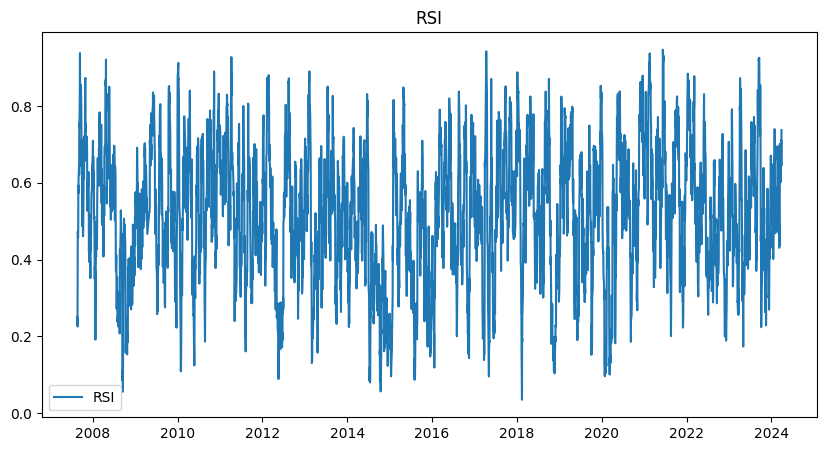

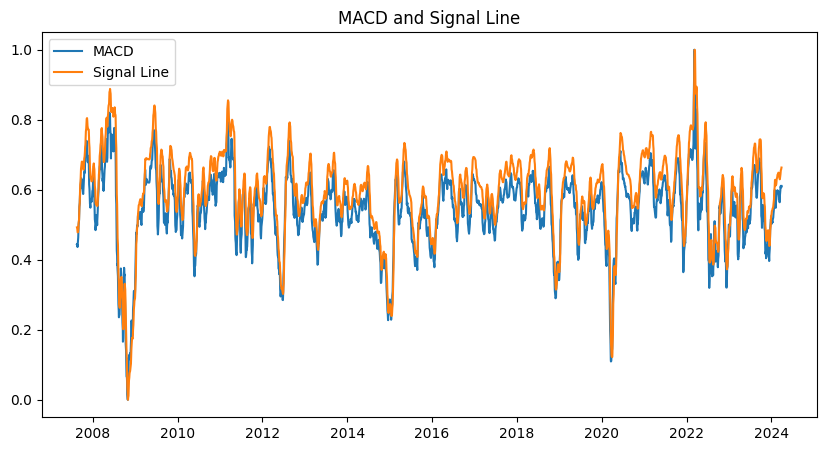

In [11]:
# plot the data for rsi
plt.figure(figsize=(10, 5))
plt.plot(dataset['RSI'], label='RSI')
plt.title('RSI')
plt.legend()
plt.show()

# plot the data for macd
plt.figure(figsize=(10, 5))
plt.plot(dataset['MACD'], label='MACD')
plt.plot(dataset['Signal_Line'], label='Signal Line')
plt.title('MACD and Signal Line')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<b>Datasets: Train, Test splitting</b>

- Train set: 90% (n of years)
- Test set: 10% (n of years)

</div>

In [12]:
# make the X 
#X=list(dataset["percent change"])

# make dataset into a dataframe

X = dataset[['percent change', 'RSI', 'MACD', 'Signal_Line']]

In [13]:
X_train , X_test = train_test_split(X, test_size=0.1, random_state=11, shuffle=False)

print("Train set length: ", len(X_train))
print("Test set length : ", len(X_test))

print("Train set start date: ", dataset.index[0])
print("Train set end date  : ", dataset.index[math.floor(len(X_train))])

print("Test set start date : ", dataset.index[math.floor(len(X_train))])
print("Test set end date   : ", dataset.index[-1])

Train set length:  3710
Test set length :  413
Train set start date:  2007-08-17 00:00:00
Train set end date  :  2022-08-09 00:00:00
Test set start date :  2022-08-09 00:00:00
Test set end date   :  2024-03-28 00:00:00


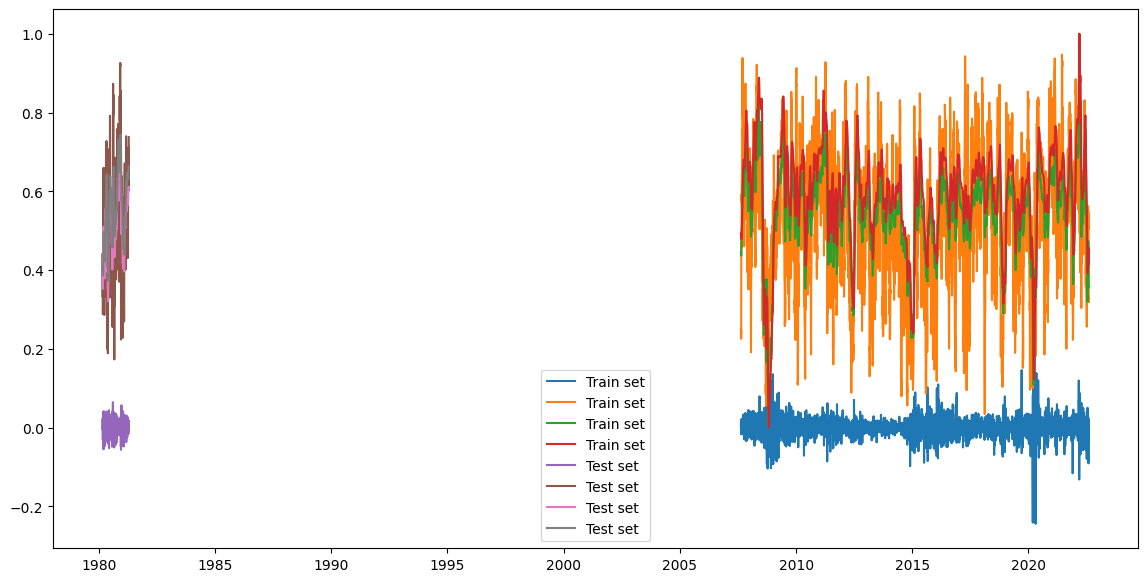

In [14]:
plt.figure(figsize=(14,7))
plt.plot(X_train, label='Train set')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test, label='Test set')
plt.legend()
plt.show()

In [15]:
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


<div class="alert alert-block alert-info">
<b>PPO algorithm</b>

</div>

In [16]:
class PPOMemory:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.memory = [] # A single list to store all memories

    def generate_batches(self):
        # Prepare the data for training
        state_arr, action_arr, probs_arr, vals_arr, reward_arr, dones_arr = zip(*self.memory)
        
        # Convert lists to PyTorch tensors
        states = torch.stack(state_arr).to(device)
        actions = torch.stack(action_arr).to(device)
        probs = torch.stack(probs_arr).to(device)
        vals = torch.stack(vals_arr).to(device)
        rewards = torch.tensor(reward_arr, dtype=torch.float32).to(device)
        dones = torch.tensor(dones_arr, dtype=torch.float32).to(device)
        
        # Create batches
        total_length = len(self.memory)
        indices = torch.randperm(total_length)
        
        batches = [{
            'states': states[indices[start:start+self.batch_size]],
            'actions': actions[indices[start:start+self.batch_size]],
            'old_probs': probs[indices[start:start+self.batch_size]],
            'vals': vals[indices[start:start+self.batch_size]],
            'rewards': rewards[indices[start:start+self.batch_size]],
            'dones': dones[indices[start:start+self.batch_size]],
        } for start in range(0, total_length, self.batch_size)]
        
        return batches

    def store_memory(self, state, action, old_prob, val, reward, done):
        self.memory.append((state, action, old_prob, val, reward, done))

    def clear_memory(self):
        self.memory.clear()

<div class="alert alert-block alert-info">
<b>Actor and Critic Neural Networks</b>



</div>

In [17]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim , dropout_rate=0.5):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(256, action_dim)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        probabilities = F.softmax(self.fc3(x), dim=-1)
        return probabilities

class Critic(nn.Module):
    def __init__(self, state_dim , dropout_rate=0.5):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        value = self.fc3(x)
        return value

<div class="alert alert-block alert-info">
<b>Environment</b>

Initial settings:


Action space:
- 0: Hold
- 1: Buy
- 2: Sell

State:
- balance_norm:
- stock_norm:
- stock_price_change:

Reward function:

</div>

In [18]:
class TradingEnvironment:
    def __init__(self, data, initial_balance=10000, buy_fee=0.001, sell_fee=0.005):
        self.data = data
        self.initial_balance = initial_balance
        self.buy_fee = buy_fee
        self.sell_fee = sell_fee
        self.reset()

    def reset(self):
        self.current_step = 0
        self.total_balance = self.initial_balance
        self.stock_owned = 0
        self.stock_price = self.data.iloc[0]['percent change']
        self.history = [self.total_balance]
        self.purchase_prices = []  # To track the purchase prices of stocks
        return self._get_obs()

    def step(self, action):
        done = False
        prev_stock_price = self.stock_price  # Save the previous price
        self.stock_price = self.data.iloc[self.current_step]['percent change']  # Update to the new price
        reward = 0  # Default reward is 0 for hold and buy actions
        
        # Calculate percent change from the previous price, if not the first step
        # percent_change = ((self.stock_price - prev_stock_price) / prev_stock_price 
        #                 if prev_stock_price and self.current_step > 0 else 0)

        if action == 1:  # Buy
            if self.total_balance >= self.stock_price * (1 + self.buy_fee):
                self.stock_owned += 1
                self.total_balance -= self.stock_price * (1 + self.buy_fee)
                self.purchase_prices.append(self.stock_price)  # Store the purchase price

                # Immediate reward/penalty for buying
                # Could be based on some condition, e.g., if RSI < 30 (oversold)
                rsi = self.data.iloc[self.current_step]['RSI']
                reward = 0.01 if rsi < 30 else -0.01

            else:
                reward = -0.01  # A penalty for illegal action

        elif action == 2:  # Sell
            if self.stock_owned > 0 and self.purchase_prices:
                self.stock_owned -= 1
                self.total_balance += self.stock_price * (1 - self.sell_fee)

                bought_price = self.purchase_prices.pop(0)  # Assuming FIFO for simplicity
                profit = (self.stock_price - bought_price) - (self.stock_price * self.sell_fee)
                reward = profit / self.initial_balance  # Normalize the reward

                # Additional penalty for selling at a loss
                if profit < 0:
                    reward *= 2  # Increase the impact of a loss

            else:
                reward = -0.01  # A penalty for illegal action

        else:  # Hold
            # Modify the holding penalty based on some condition
            # Example: Penalize more if the stock is deemed to be in a downtrend
            macd =self.data.iloc[self.current_step]['MACD']
            signal_line = self.data.iloc[self.current_step]['Signal_Line']
            reward = -0.01 if macd < signal_line else -0.0005



        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True

        next_state = self._get_obs()
        self.history.append(self.total_balance)
        
        return next_state, reward, done, {}

    def _get_obs(self):
        # Obtain percent change from the previous step, if possible
        if self.current_step > 0 and self.data.iloc[self.current_step - 1]['percent change'] != 0:
            stock_price_change = (self.data.iloc[self.current_step]['percent change'] - self.data.iloc[self.current_step - 1]['percent change']) / self.data.iloc[self.current_step - 1]['percent change']
        else:
            stock_price_change = 0

        balance_norm = self.total_balance / self.initial_balance
        stock_norm = self.stock_owned / max(self.stock_owned, 1)  # Avoid division by zero

        # Select the features for the current step
        features = self.data.iloc[self.current_step][['percent change', 'RSI', 'MACD', 'Signal_Line']]
        
        # Normalize the selected features
        # Assuming self.data.mean() and self.data.std() are precomputed for the entire dataset
        normalized_features = (features - self.data[['percent change', 'RSI', 'MACD', 'Signal_Line']].mean()) / self.data[['percent change', 'RSI', 'MACD', 'Signal_Line']].std()

        # Concatenate all state information
        state = np.concatenate((np.array([balance_norm, stock_norm, stock_price_change]), normalized_features.values), axis=None)

        return torch.tensor(state, dtype=torch.float).to(device)


    def render(self):
        pass

<div class="alert alert-block alert-info">
<b>Agent</b>

</div>

In [19]:
class Agent:
    def __init__(self, state_dim, action_dim, gamma=0.7, alpha=0.0001, gae_lambda=0.98, policy_clip=0.8, batch_size=64, n_epochs=10):
        self.gamma = gamma # Discount factor : How much to weight immediate rewards
        self.policy_clip = policy_clip # Clipping parameter epsilon: How much to clip the ratio in PPO (to prevent too large policy update)
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda # Lambda parameter for Generalized Advantage Estimation: How much to weight future rewards
        self.batch_size = batch_size 

        
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim).to(device)

        L2_value = 1e-2
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=alpha, weight_decay=L2_value)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=alpha, weight_decay=L2_value)

        self.memory = []
    

    def evaluate(self, state, action):
        action_probs = self.actor(state)
        dist = Categorical(probs=action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy


    def act(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)
        probabilities = self.actor(state)
        dist = Categorical(probs=probabilities)
        action = dist.sample()
        return action.item(), dist.log_prob(action).item()

    
    def store_transition(self, state, action, log_prob, reward, done):
        self.memory.append((state, action, log_prob, reward, done))

    
    def learn(self):
        rewards = []
        is_terminals = []
        old_states = []
        old_actions = []
        old_logprobs = []

        # Extract information from memory
        for state, action, log_prob, reward, done in self.memory:
            old_states.append(state)
            old_actions.append(action)
            old_logprobs.append(log_prob)
            rewards.append(reward)
            is_terminals.append(done)

        old_states = torch.stack(old_states).to(device)
        old_actions = torch.stack([torch.tensor(a, dtype=torch.long) for a in old_actions]).to(device)
        old_logprobs = torch.stack([torch.tensor(lp, dtype=torch.float) for lp in old_logprobs]).to(device)
        
        # Normalize the rewards
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # Convert is_terminals to tensor
        is_terminals = torch.tensor(is_terminals, dtype=torch.float).to(device)

        # Calculating the advantages
        advantages = []
        prev_advantage = 0
        for t in reversed(range(len(rewards))):
            if is_terminals[t]:
                delta = rewards[t] - self.critic(old_states[t])
                prev_advantage = delta
            else:
                delta = rewards[t] + self.gamma * self.critic(old_states[t + 1]) - self.critic(old_states[t])
                prev_advantage = delta + self.gamma * self.gae_lambda * prev_advantage
            advantages.insert(0, prev_advantage)
        advantages = torch.tensor(advantages, dtype=torch.float).to(device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        # Optimize policy for K epochs
        for _ in range(self.n_epochs):
            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta_old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.policy_clip, 1+self.policy_clip) * advantages

            # Final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * (state_values - rewards)**2 - 0.01 * dist_entropy

            # Take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            loss.mean().backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

        
        self.memory.clear()

<div class="alert alert-block alert-info">
<b>Training</b>

</div>

In [20]:
def evaluate_agent(env, agent, episodes=100):
    agent.actor.eval()
    agent.critic.eval()

    episode_rewards = []
    for _ in tqdm(range(episodes)):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = agent.act(state)  # Use the agent to decide on an action
            next_state, reward, done, _ = env.step(action)  # Apply the action to the environment
            state = next_state
            episode_reward += reward
        episode_rewards.append(episode_reward)
    return episode_rewards

In [21]:
state_dim = 7
action_dim = 3
episode_count = 50#300
evaluation_interval = 10

# Initialize the environments
env = TradingEnvironment(data=X_train)
env_test = TradingEnvironment(data=X_test) 
agent = Agent(state_dim=state_dim, action_dim=action_dim, n_epochs=10, batch_size=16)

episode_rewards = []
evaluation_rewards = []

number_of_buy_actions = []
number_of_sell_actions = []
number_of_hold_actions = []

pbar = tqdm(range(episode_count + 1), desc='Training Progress')
for episode in pbar:
    state = env.reset()  # State is now a torch tensor
    total_episode_reward = 0

    buy_action_count = 0
    sell_action_count = 0
    hold_action_count = 0

    while True:
        
        action, log_prob = agent.act(state)
        next_state, reward, done, _ = env.step(action)

        if action == 1:
            buy_action_count += 1
        elif action == 2:
            sell_action_count += 1
        else:
            hold_action_count += 1
        
        # Store transition in agent memory as tensors
        agent.store_transition(state, action, log_prob, reward, done)
        
        state = next_state
        total_episode_reward += reward


        if done:
            break

    agent.learn()

    episode_rewards.append(total_episode_reward)

    number_of_buy_actions.append(buy_action_count)
    number_of_sell_actions.append(sell_action_count)
    number_of_hold_actions.append(hold_action_count)

    if episode % evaluation_interval == 0:
        eval_reward = evaluate_agent(env_test, agent, episodes=1)
        evaluation_rewards.append(eval_reward[0])  # Assuming evaluation on a single episode

        agent.actor.train()
        agent.critic.train()
        
    # Update progress bar description
    pbar.set_description(f"Training Reward: {total_episode_reward:.3f} | "
                         f"Evaluation Reward: {evaluation_rewards[-1] if evaluation_rewards else 'N/A'}")
    pbar.refresh()

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]1.1562937891312508:  20%|█▉        | 10/51 [01:20<05:26,  7.96s/it]
Training Reward: 36.439 | Evaluation Reward: 3.969993132649316:  29%|██▉       | 15/51 [02:00<04:50,  8.06s/it] 

<div class="alert alert-block alert-info">
<b>Evaluation</b>

- Plot the total reward per episode over the training
- Every 10 training episodes, evaluate the model on the test set and log the results

</div>

In [ ]:
# Plotting the training and evaluation rewards
plt.figure(figsize=(14, 7))

# Plot training rewards
plt.plot(episode_rewards, label='Training Rewards', color='blue', alpha=0.5)

# Plot evaluation rewards, using range to align with the training episodes
plt.plot(range(0, episode_count + 1, evaluation_interval), evaluation_rewards, 
            label='Evaluation Rewards', color='red')

plt.title('Training and Evaluation Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.show()


# plot the number of actions over episodes
plt.plot(number_of_buy_actions, label='Buy Actions')
plt.plot(number_of_sell_actions, label='Sell Actions')
plt.plot(number_of_hold_actions, label='Hold Actions')
plt.title('Actions Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Number of Actions')
plt.legend()

---

# Check for overfitting

In [ ]:
env_test = TradingEnvironment(data=X_test)


# Evaluate on the training environment
train_rewards = evaluate_agent(env, agent, episodes=10)

# Evaluate on the test environment
test_rewards = evaluate_agent(env_test, agent, episodes=10)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_rewards, label='Training Rewards', color='blue')
plt.plot(test_rewards, label='Test Rewards', color='red')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Agent Performance on Training vs. Test Data')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<b>Results</b>

</div>

In [ ]:
def test_agent(env, agent, episodes=100):
    total_rewards = []
    action_counts = {'buy': 0, 'sell': 0, 'hold': 0}

    for episode in tqdm(range(episodes)):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action, _ = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_reward += reward

            if action == 1:
                action_counts['buy'] += 1
            elif action == 2:
                action_counts['sell'] += 1
            else:
                action_counts['hold'] += 1
        
        total_rewards.append(episode_reward)

    return total_rewards, action_counts


In [ ]:
test_env = TradingEnvironment(data=X_test)

agent.actor.eval()
agent.critic.eval()

total_rewards, action_counts = test_agent(test_env, agent, episodes=100)

In [ ]:
def plot_rewards(rewards_list):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_list, label='Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.legend()
    plt.show()

plot_rewards(total_rewards)

In [ ]:
def plot_action_distribution(action_counts):
    labels = action_counts.keys()
    counts = action_counts.values()

    plt.figure(figsize=(7, 5))
    plt.bar(labels, counts, color=['blue', 'green', 'red'])
    plt.xlabel('Actions')
    plt.ylabel('Count')
    plt.title('Action Distribution Over All Episodes')
    plt.show()

plot_action_distribution(action_counts)

In [ ]:
def plot_portfolio_value(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history, label='Portfolio Value')
    plt.xlabel('Time Step')
    plt.ylabel('Total Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.legend()
    plt.show()

plot_portfolio_value(env.history)